# Transfer Learning with TensorFlow Part 1: Feature Extraction



In [6]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [7]:
print(tf.config.list_physical_devices())
tf.device('/physical_device:GPU:0')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-12 17:08:01.431642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-12 17:08:01.431660: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-12 17:08:01.431666: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-12 17:08:01.431721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 17:08:01.431760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
import os

directory = "10_food_classes_10_percent"

# Print the list of files
for dirpath, dirnames, filenames in os.walk(directory):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
  


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = f"{directory}/train"
test_dir = f"{directory}/test"

train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)

print("Training images:")
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

print("Testing images:")
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Callbacks -

* Tracking experiments with Tensorboard Callback
* Model checkpoint
* Stopping model before it overfits

In [10]:
from datetime import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback



In [69]:
efficientnet_v2 = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b0-feature-vector/versions/1"
efficientnet_v2_b1 = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b1-feature-vector/versions/1"
efficientnet_v2_b2 = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b2-feature-vector/versions/1"
efficientnet_v2_b3 = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1"
mobilenet_v3 = "https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-feature-vector/versions/1"


In [12]:
import tensorflow_hub as hub


In [13]:
def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SIZE + (3,),
    ) 

    model = tf.keras.Sequential(
        [
            feature_extractor_layer, 
            tf.keras.layers.Dense(
                num_classes, activation="softmax", name="output_layer"
            ),
        ]
    )

    return model

In [43]:
from helper import plot_loss_curves

In [44]:
model_1_efficientnet = create_model(efficientnet_v2, train_data.num_classes)

In [45]:
model_1_efficientnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [46]:
model_1_efficientnet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [47]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
tf.device(tf.config.list_physical_devices()[0].name)

In [49]:
model_1_history = model_1_efficientnet.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "model_1_efficientnet")],
)

Saving TensorBoard log files to: tensorflow_hub/model_1_efficientnet/20240112-171715
Epoch 1/5


2024-01-12 17:17:18.301744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 19s 654ms/step - loss: 1.9398 - accuracy: 0.4507 - val_loss: 0.7865 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 10s 439ms/step - loss: 0.6255 - accuracy: 0.8000 - val_loss: 0.4914 - val_accuracy: 0.8336
Epoch 3/5
24/24 [==============================] - 10s 427ms/step - loss: 0.3974 - accuracy: 0.8840 - val_loss: 0.4329 - val_accuracy: 0.8568
Epoch 4/5
24/24 [==============================] - 10s 429ms/step - loss: 0.2791 - accuracy: 0.9253 - val_loss: 0.3895 - val_accuracy: 0.8724
Epoch 5/5
24/24 [==============================] - 10s 416ms/step - loss: 0.1976 - accuracy: 0.9533 - val_loss: 0.3851 - val_accuracy: 0.8732


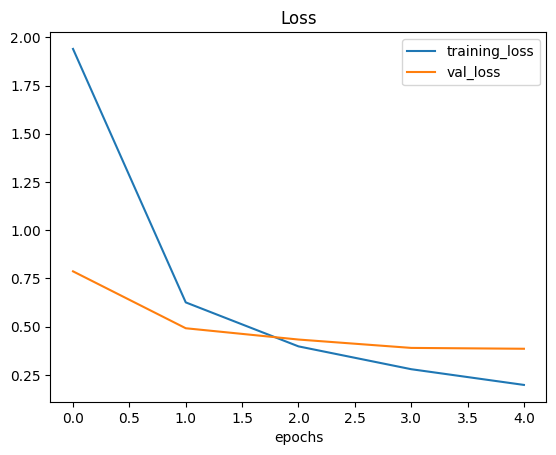

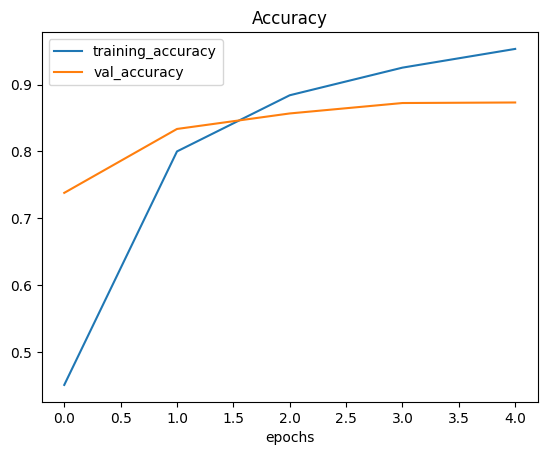

In [50]:
plot_loss_curves(model_1_history)

In [61]:
model_2_mobilenet = create_model(mobilenet_v3, train_data.num_classes)

model_2_mobilenet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_2_history = model_2_mobilenet.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "model_2_mobilenet")],
)

Saving TensorBoard log files to: tensorflow_hub/model_2_mobilenet/20240112-172226
Epoch 1/5
24/24 [==============================] - 19s 679ms/step - loss: 1.9018 - accuracy: 0.3800 - val_loss: 1.3236 - val_accuracy: 0.6840
Epoch 2/5
24/24 [==============================] - 8s 338ms/step - loss: 1.0432 - accuracy: 0.7760 - val_loss: 0.8627 - val_accuracy: 0.8096
Epoch 3/5
24/24 [==============================] - 8s 335ms/step - loss: 0.7246 - accuracy: 0.8480 - val_loss: 0.6916 - val_accuracy: 0.8344
Epoch 4/5
24/24 [==============================] - 8s 331ms/step - loss: 0.5737 - accuracy: 0.8813 - val_loss: 0.6120 - val_accuracy: 0.8428
Epoch 5/5
24/24 [==============================] - 7s 314ms/step - loss: 0.4726 - accuracy: 0.9067 - val_loss: 0.5681 - val_accuracy: 0.8428


In [62]:
model_2_mobilenet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              2731616   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2744426 (10.47 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


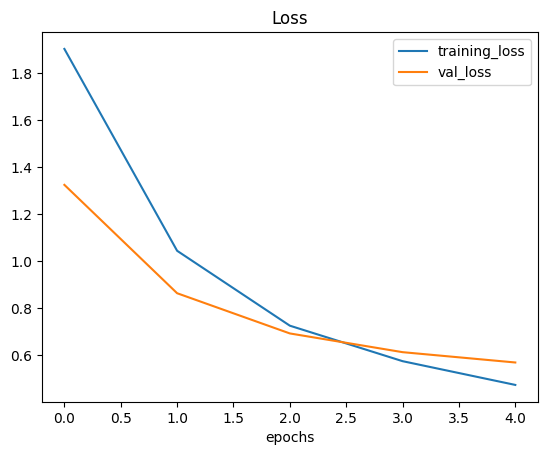

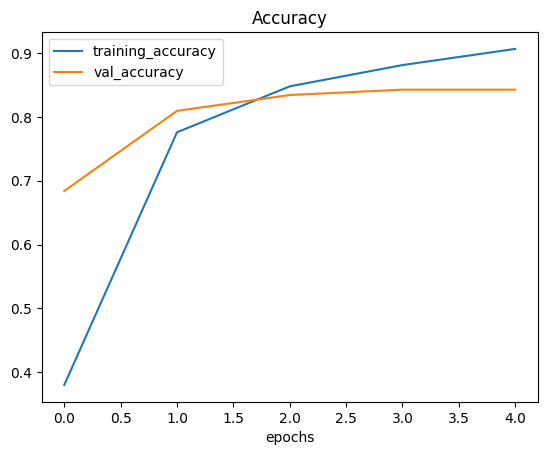

In [63]:
plot_loss_curves(model_2_history)

In [70]:
model_3_efficientnet_b1 = create_model(efficientnet_v2_b1, train_data.num_classes)

model_3_efficientnet_b1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_3_history = model_3_efficientnet_b1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "model_3_efficientnet_b1")],
)

Saving TensorBoard log files to: tensorflow_hub/model_3_efficientnet_b1/20240112-173420
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 2.0157 - accuracy: 0.3360 - val_loss: 1.0535 - val_accuracy: 0.6844
Epoch 2/5
24/24 [==============================] - 14s 587ms/step - loss: 0.7344 - accuracy: 0.7840 - val_loss: 0.5602 - val_accuracy: 0.8284
Epoch 3/5
24/24 [==============================] - 13s 539ms/step - loss: 0.4685 - accuracy: 0.8640 - val_loss: 0.4528 - val_accuracy: 0.8604
Epoch 4/5
24/24 [==============================] - 14s 582ms/step - loss: 0.3532 - accuracy: 0.8973 - val_loss: 0.4106 - val_accuracy: 0.8736
Epoch 5/5
24/24 [==============================] - 13s 537ms/step - loss: 0.2693 - accuracy: 0.9307 - val_loss: 0.3835 - val_accuracy: 0.8796


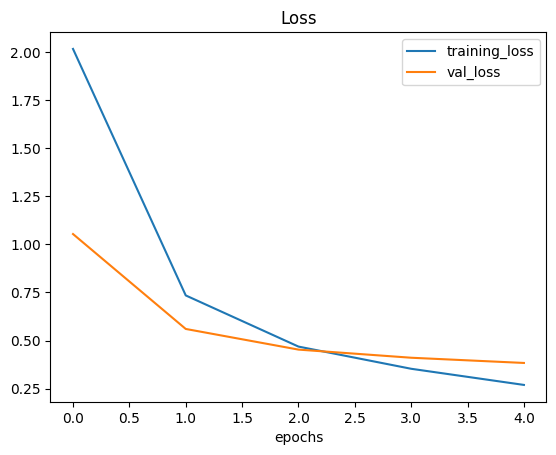

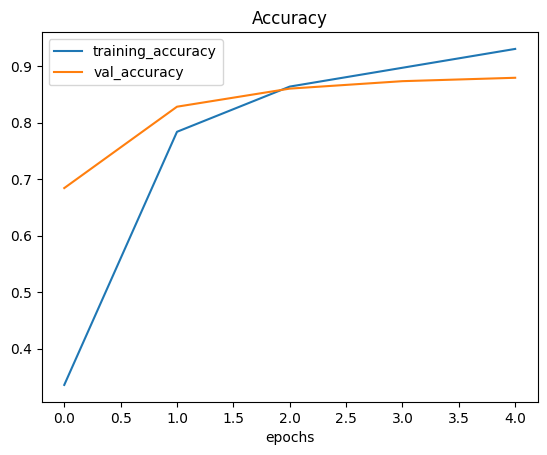

In [71]:
plot_loss_curves(model_3_history)

In [72]:
model_4_efficientnet_b2 = create_model(efficientnet_v2_b2, train_data.num_classes)

model_4_efficientnet_b2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_4_history = model_4_efficientnet_b2.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "model_4_efficientnet_b2")],
)

Saving TensorBoard log files to: tensorflow_hub/model_4_efficientnet_b2/20240112-173600
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 2.0321 - accuracy: 0.4160 - val_loss: 0.8262 - val_accuracy: 0.7144
Epoch 2/5
24/24 [==============================] - 16s 688ms/step - loss: 0.5847 - accuracy: 0.8227 - val_loss: 0.4483 - val_accuracy: 0.8480
Epoch 3/5
24/24 [==============================] - 16s 678ms/step - loss: 0.3314 - accuracy: 0.9013 - val_loss: 0.3972 - val_accuracy: 0.8624
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.2498 - accuracy: 0.9293 - val_loss: 0.3674 - val_accuracy: 0.8736
Epoch 5/5
24/24 [==============================] - 15s 628ms/step - loss: 0.1696 - accuracy: 0.9600 - val_loss: 0.3483 - val_accuracy: 0.8848


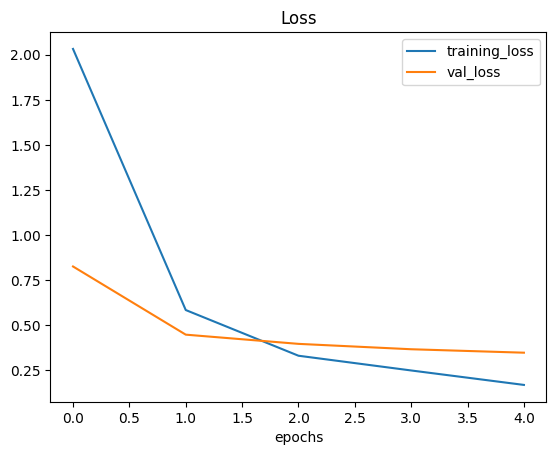

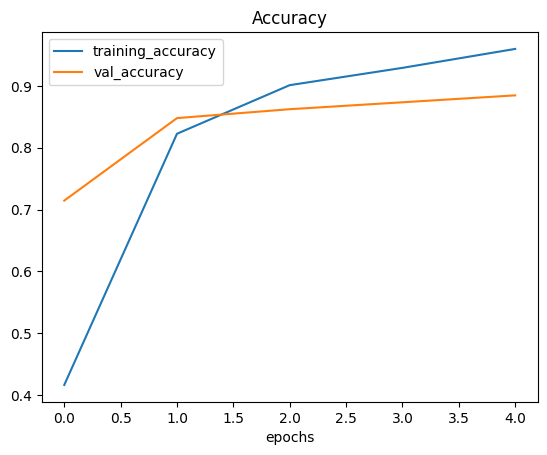

In [73]:
plot_loss_curves(model_4_history)

In [74]:
model_5_efficientnet_b3 = create_model(efficientnet_v2_b3, train_data.num_classes)

model_5_efficientnet_b3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_5_history = model_5_efficientnet_b3.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "model_5_efficientnet_b3")],
)

Saving TensorBoard log files to: tensorflow_hub/model_5_efficientnet_b3/20240112-173801
Epoch 1/5
24/24 [==============================] - 52s 2s/step - loss: 2.0009 - accuracy: 0.4187 - val_loss: 0.5907 - val_accuracy: 0.8112
Epoch 2/5
24/24 [==============================] - 23s 994ms/step - loss: 0.4639 - accuracy: 0.8547 - val_loss: 0.3684 - val_accuracy: 0.8796
Epoch 3/5
24/24 [==============================] - 20s 877ms/step - loss: 0.2745 - accuracy: 0.9133 - val_loss: 0.3168 - val_accuracy: 0.8956
Epoch 4/5
24/24 [==============================] - 20s 866ms/step - loss: 0.1802 - accuracy: 0.9547 - val_loss: 0.3034 - val_accuracy: 0.9008
Epoch 5/5
24/24 [==============================] - 21s 888ms/step - loss: 0.1272 - accuracy: 0.9747 - val_loss: 0.2956 - val_accuracy: 0.9008


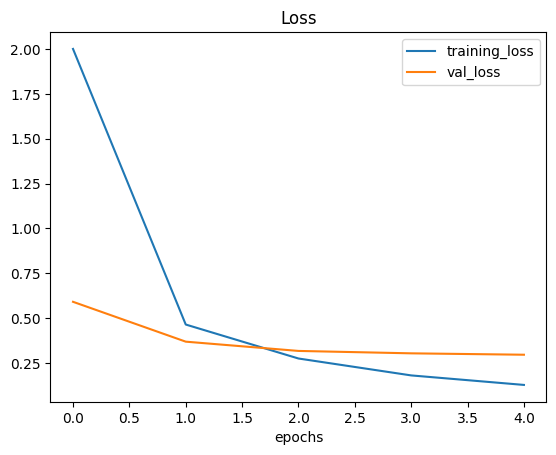

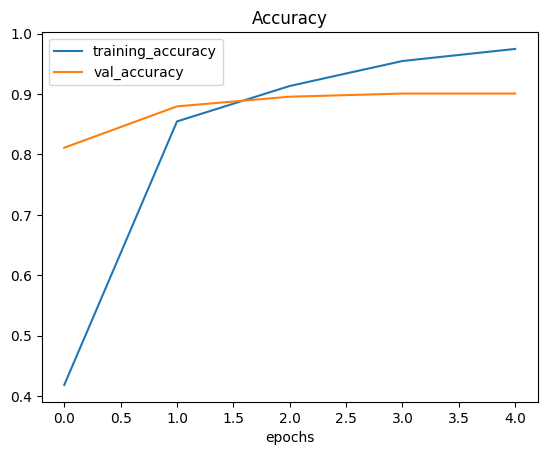

In [75]:
plot_loss_curves(model_5_history)

In [76]:
print(f"Layers in model_1_efficientnet: {len(model_1_efficientnet.layers[0].weights)}")
print(f"Layers in model_2_mobilenet: {len(model_2_mobilenet.layers[0].weights)}")
print(f"Layers in model_3_efficientnet_b1: {len(model_3_efficientnet_b1.layers[0].weights)}")
print(f"Layers in model_4_efficientnet_b2: {len(model_4_efficientnet_b2.layers[0].weights)}")
print(f"Layers in model_5_efficientnet_b3: {len(model_5_efficientnet_b3.layers[0].weights)}")



Layers in model_1_efficientnet: 359
Layers in model_2_mobilenet: 264
Layers in model_3_efficientnet_b1: 441
Layers in model_4_efficientnet_b2: 460
Layers in model_5_efficientnet_b3: 536


In [1]:
# %tensorboard --logdir ./tensorflow_hub/ --port 2222
